# Modelo con una intención por predictor

En esta sección del notebook se crearan modelos diferentes para cada intención del dataset. De esta manera se puede realizar un análisis específico de cada intención y crear modelos a medida para cada una de ellas, con la esperanza de obtener un clasificador con suficiente precisión como para predecir datos fiables.

Se comenzará analizando la proporción de positivos y negativos en el dataset para ver si no se encuentra balanceado. Como en este caso se encuentra muy poco balanceado se hace uso de un algoritmo llamado ADASYN que balancea dataset media el over sampling (Generar más casos de entrenamiento). ADASYN es una versión mejorada de otro algoritmo llamado SMOTE. SMOTE encuentra el vecino n más cercano en la clase con menor proporción y crea una linea entre los vecinos. Una vez hecho esto, genera puntos aleatorios en las lineas. Así, ADASYN lo mejora ligeramente pues al crear esos datos añado pequeños valores a ellos mismos haciendolos más realistas. Este método casi seguramente incrementará la tendencia del modelo al overfit, por ello uno de los algoritmos utilizados será Random Forest, robusto frente al overfit y probablemente efectivo en esta tarea de clasificación.

Una vez balanceado el dataset se aplica feature engineering utilizando el enfoce Model-Based en el cual la importancia de los atributos es determinada por un algoritmo clasificador seleccionado. Se especifica un threshold y todos los atributos cuya importancia sea mayor al threshold serán utilizados mientras que los demás son descartados. Se calcularán métricas como el área bajo la curva ROC para comparar resultados del dataset tras feature engineering y el original.

Una vez hecho esto comienza la selección del algoritmo clasificador. En este caso diferentes algoritmos han sido testeados mediante diferentes técnicas. RandomForest y SVMs. El motivo por el cual he decidido usar estos clasificadores es básicamente el tipo de datos utilizados. Se trata de una tarea de clasificación binaria con un dataset de tamaño reducido pero con un número alto de atributos. Los atributos, además, son de tipo FLOAT. Dado que es binaria KNN no iba a dar resultados, Naive Bayes no nos es útil tampoco pues los atributos no son texto. Al no ser una predicción de cantidad algoritmos de regresión o Lasso, etc... no son los más adecuados. Además por cantidad de datos una red neuronal probablemente tenga problemas de precisión al ser un dataset de solo 5500 muetras.

Una vez el tuning de los diferentes modelos se ha realizado se generan gráficas para poder comparar resultados. En base a eso seleccionar el mejor modelo con los mejores hiperparámetros para cada intención y crear pipelines con el modelo entrenado y feature engineering en casos que sea necesario para exportarlas y ser usadas para predecir nuevos datasets sin necesidad de ejecutar y modificar el notebook cada vez. 

Por último, se crea un fichero con las labels predecidas y se edita el fichero del dump de la wiki inicial añadiendo las labels de cara a dejarlo listo para ser analizado mediante la minería de procesos


In [4]:
import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm

#Load of the dataset and split in training and test set
dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
#Figures size
plt.rcParams['savefig.dpi'] = 100




In [10]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [200]:
print("Number of rows in data =",dataset.shape[0])
print("Number of columns in data =",dataset.shape[1])
print("Number of NULL values in data =", dataset.isnull().values.any())
print("\n")
print("Data sample")
#Remember that printing the method head() generates the ugliest table
dataset.head(n = 10)



Number of rows in data = 5690
Number of columns in data = 222
Number of NULL values in data = False


Data sample


,feats_0,feats_1,feats_2,feats_3,feats_4,feats_5,feats_6,feats_7,feats_8,feats_9,...,other,wikification,vandalism,simplification,elaboration,verifiability,process,clarification,disambiguation,point-of-view
0,741692138,0.0,0.0,-1.0,0.0,555.0,926.0,12.0,8.0,42.0,...,1,0,0,0,0,0,0,0,0,0
1,741692138,0.0,0.0,-1.0,0.0,555.0,926.0,12.0,8.0,42.0,...,1,0,0,0,0,0,0,0,0,0
2,710764506,0.0,0.0,-1.0,0.0,3.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,711588802,0.0,0.0,-1.0,0.0,9.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,709526386,0.0,0.0,-1.0,0.0,326.0,269.0,0.0,0.0,24.0,...,0,0,0,0,0,0,0,0,0,0
5,713098731,0.0,0.0,-1.0,0.0,190.0,0.0,8.0,0.0,7.0,...,0,0,0,0,0,1,0,0,0,0
6,713936284,0.0,0.0,-1.0,0.0,65.0,35.0,0.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
7,710197768,0.0,0.0,-1.0,1.0,886.0,3861.0,14.0,33.0,135.0,...,0,0,0,0,0,0,0,0,0,0
8,709472909,0.0,0.0,-1.0,0.0,0.0,67.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9,713345346,0.0,0.0,-1.0,1.0,404.0,80.0,6.0,3.0,61.0,...,0,0,0,0,1,0,0,0,0,0


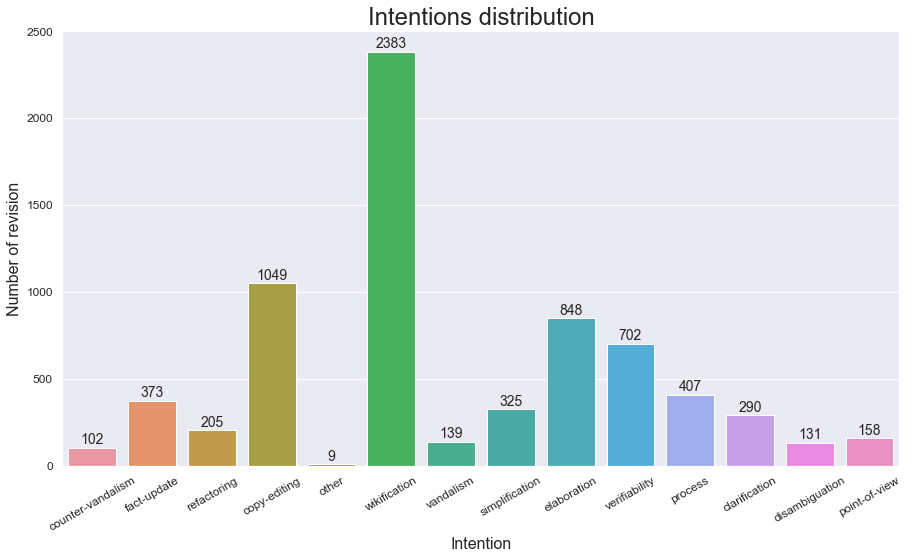

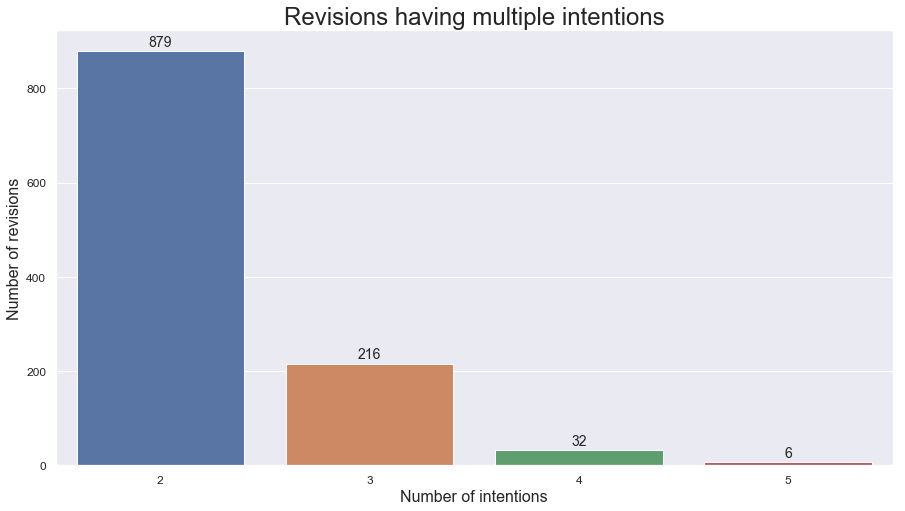

In [201]:
categories = intentions
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions distribution", fontsize=24)
plt.ylabel('Number of revision', fontsize=16)
plt.xlabel('Intention', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or string like 'vertical'
    tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#adding the text labels
rects = ax.patches
labels = dataset.iloc[:,-14:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
#plt.xticks(intentions,rotation = 30)

plt.show()

rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Revisions having multiple intentions")
plt.ylabel('Number of revisions', fontsize=16)
plt.xlabel('Number of intentions', fontsize=16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#plt.xticks(multiLabel_counts.index, fontsize = 12)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
plt.show()

Proporción de labels en el dataset


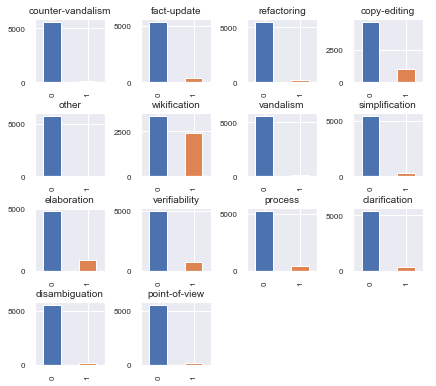

In [202]:

#Charts of the label proportions in the original dataset
print("Proporción de labels en el dataset")
i = 1

for intention in intentions:
    df = pandas.DataFrame(X)
    df['target'] = y[intention]
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    i += 1
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()



In [203]:
rowSums = dataset.iloc[:,-14:].sum(axis=0)
proportions = []
for intention in intentions:
    proportions.append(rowSums[intention]/dataset.shape[0] * 100)

df = pandas.DataFrame({ 'intention':intentions, 'count':rowSums.values, '% of appearance': proportions})
df.head(14)


,intention,count,% of appearance
0,counter-vandalism,102,1.792619
1,fact-update,373,6.555360
2,refactoring,205,3.602812
3,copy-editing,1049,18.435852
4,other,9,0.158172
5,wikification,2383,41.880492
6,vandalism,139,2.442882
7,simplification,325,5.711775
8,elaboration,848,14.903339
9,verifiability,702,12.337434


In [204]:
rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
proportions = []
for i in range(1,6):
    proportions.append(multiLabel_counts[i]/dataset.shape[0] * 100)
df = pandas.DataFrame({ 'Number of intentions':multiLabel_counts.index, 'count':multiLabel_counts.values, '% of appearance': proportions})
df.head(5)

,Number of intentions,count,% of appearance
0,1,4557,80.087873
1,2,879,15.448155
2,3,216,3.796134
3,4,32,0.562390
4,5,6,0.105448


In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#This is used numerous times throughout the notebook to generate the roc_auc scores easily 
#The roc_auc scores are calculated in order to be plotted
#source: Ignacio Garcia antonio caparrini y laura perez. e-prints.
def calculate_roc(model, X, y):
    
    y_pred = model.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

#This method creates a "y" dataset with multilabel format instead of the original with each intention separated
#source: Ignacio Garcia
def creating_multilabel(y):
    
    labels = [None] * len(y.index)

    #output = pandas.DataFrame.to_dict(output)

    for intention in intentions:

        offset = 0

        for line in y[intention]:

            if labels[offset] == None:
                labels[offset] = []
            if line == 1:
                labels[offset].append(str(intention))

            offset += 1

    return labels

#source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [206]:
#Setting of a dummy model to create a baseline 
#data to collect : Accuracy, precision, recall, f1_score (micro and macro also)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



dummy_precision = []
dummy_recall = []
dummy_f1 = []
dummy_f1_micro = []
dummy_f1_macro = []
dummy_accuracy = []

for intention in intentions:
    
    baseline_model = DummyClassifier(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    dummy_precision.append(precision_score(y_test[intention], y_pred))
    dummy_recall.append(recall_score(y_test[intention], y_pred))
    dummy_f1.append(f1_score(y_test[intention], y_pred))
    dummy_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    dummy_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    dummy_accuracy.append(accuracy_score(y_test[intention], y_pred))
    
dummy_model_data = pandas.DataFrame({'Intention':intentions,'Precision':dummy_precision, 'Recall': dummy_recall
                                     , 'Accuracy':dummy_accuracy, 'F1 Binary':dummy_f1, 'F1 micro': dummy_f1_micro
                                     , 'F1 macro': dummy_f1_macro })
dummy_model_data.head(15)



,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.000000,0.000000,0.971880,0.000000,0.971880,0.492870
1,fact-update,0.070175,0.052632,0.890158,0.060150,0.890158,0.500910
2,refactoring,0.027027,0.023810,0.932337,0.025316,0.932337,0.495134
3,copy-editing,0.162162,0.149254,0.713533,0.155440,0.713533,0.491477
4,other,0.000000,0.000000,0.998243,0.000000,0.998243,0.499560
5,wikification,0.410714,0.380952,0.505272,0.395274,0.505272,0.488343
6,vandalism,0.090909,0.060606,0.955185,0.072727,0.955185,0.524882
7,simplification,0.078431,0.055556,0.898946,0.065041,0.898946,0.505813
8,elaboration,0.131034,0.109827,0.753954,0.119497,0.753954,0.488247
9,verifiability,0.043478,0.040000,0.797891,0.041667,0.797891,0.464350


In [207]:
base_rf_precision = []
base_rf_recall = []
base_rf_f1 = []
base_rf_f1_micro = []
base_rf_f1_macro = []
base_rf_accuracy = []

for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_rf_precision.append(precision_score(y_test[intention], y_pred))
    base_rf_recall.append(recall_score(y_test[intention], y_pred))
    base_rf_f1.append(f1_score(y_test[intention], y_pred))
    base_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

base_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision, 'Recall': base_rf_recall
                                     , 'Accuracy':base_rf_accuracy, 'F1 Binary':base_rf_f1, 'F1 micro': base_rf_f1_micro
                                     , 'F1 macro': base_rf_f1_macro })
base_rf_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,1.000000,0.250000,0.989455,0.400000,0.989455,0.697340
1,fact-update,0.791667,0.250000,0.945518,0.380000,0.945518,0.675754
2,refactoring,0.615385,0.190476,0.965729,0.290909,0.965729,0.636675
3,copy-editing,0.760331,0.457711,0.878735,0.571429,0.878735,0.750402
4,other,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
5,wikification,0.784841,0.664596,0.780316,0.719731,0.780316,0.769548
6,vandalism,0.818182,0.272727,0.977153,0.409091,0.977153,0.698721
7,simplification,0.758621,0.305556,0.949912,0.435644,0.949912,0.704718
8,elaboration,0.700000,0.566474,0.897188,0.626198,0.897188,0.783298
9,verifiability,0.793814,0.616000,0.940246,0.693694,0.940246,0.830294


In [208]:
base_svc_precision = []
base_svc_recall = []
base_svc_f1 = []
base_svc_f1_micro = []
base_svc_f1_macro = []
base_svc_accuracy = []

for intention in intentions:
    
    baseline_model = LinearSVC(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_svc_precision.append(precision_score(y_test[intention], y_pred))
    base_svc_recall.append(recall_score(y_test[intention], y_pred))
    base_svc_f1.append(f1_score(y_test[intention], y_pred))
    base_svc_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_svc_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_svc_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

base_svc_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_svc_precision, 'Recall': base_svc_recall
                                     , 'Accuracy':base_svc_accuracy, 'F1 Binary':base_svc_f1, 'F1 micro': base_svc_f1_micro
                                     , 'F1 macro': base_svc_f1_macro })
base_svc_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.0,0.000000,0.985940,0.000000,0.985940,0.496460
1,fact-update,0.0,0.000000,0.933216,0.000000,0.933216,0.482727
2,refactoring,0.0,0.000000,0.963093,0.000000,0.963093,0.490600
3,copy-editing,0.0,0.000000,0.823374,0.000000,0.823374,0.451566
4,other,0.0,0.000000,1.000000,0.000000,1.000000,1.000000
5,wikification,0.5,0.488613,0.575571,0.494241,0.575571,0.564304
6,vandalism,0.0,0.000000,0.971002,0.000000,0.971002,0.492644
7,simplification,0.0,0.000000,0.936731,0.000000,0.936731,0.483666
8,elaboration,0.0,0.000000,0.847979,0.000000,0.847979,0.458868
9,verifiability,0.0,0.000000,0.890158,0.000000,0.890158,0.470944


In [209]:
averages_dummy = []
averages_svc = []
averages_rf = []

for column in dummy_model_data.iloc[:,1:].columns:
    averages_dummy.append(dummy_model_data[column].sum()/dummy_model_data.shape[0])
    averages_svc.append(base_svc_model_data[column].sum()/dummy_model_data.shape[0])
    averages_rf.append(base_rf_model_data[column].sum()/dummy_model_data.shape[0])

base_models_data = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data['Dummy classifier'] = averages_dummy
base_models_data['SVC classifier'] = averages_svc
base_models_data['Random Forest classifier'] = averages_rf
base_models_data.head(15)

,Dummy classifier,SVC classifier,Random Forest classifier
Precision,0.088793,0.035714,0.712241
Recall,0.075479,0.034901,0.310874
Accuracy,0.865993,0.910808,0.941250
F1 Binary,0.081318,0.035303,0.407647
F1 micro,0.865993,0.910808,0.941250
F1 macro,0.498313,0.524762,0.721357


In [210]:
#Generation of a "new" train set for each intention, this way we can perform feature engineering specific for each intention
#so that the best features for each intention are selected
X_train_ = {'counter-vandalism':X_train,'fact-update':X_train,'refactoring':X_train,'copy-editing':X_train,'other':X_train,'wikification':X_train,
            'vandalism':X_train,'simplification':X_train,'elaboration':X_train,'verifiability':X_train,'process':X_train,'clarification':X_train,
            'disambiguation':X_train,'point-of-view':X_train}
y_train_ = {}

In [211]:
#Resampling via over_sampling with ADASYN to generate the previously mention new train sets for each intention balanced.
for intention in intentions:
    
    sm = ADASYN()
    X_train_[intention], y_train_[intention] = sm.fit_resample(X_train, y_train[intention])

#Now we have the test and set splits done and the data is ready to be analyzed and modeled.

Proporción de labels en el dataset tras realizar Over Sampling


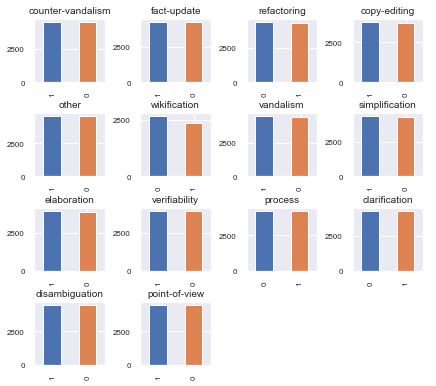

In [212]:
#Chart of the label proportions in the sampled datasets
print("Proporción de labels en el dataset tras realizar Over Sampling")
i = 1
for intention in intentions:
    df = pandas.DataFrame(X_train_[intention])
    df['target'] = y_train_[intention]
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    i += 1
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()

In [213]:
#Setting of a dummy model to create a baseline 
#data to collect : Accuracy, precision, recall, f1_score (micro and macro also)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



dummy_precision_os = []
dummy_recall_os = []
dummy_f1_os = []
dummy_f1_micro_os = []
dummy_f1_macro_os = []
dummy_accuracy_os = []

for intention in intentions:
    
    baseline_model = DummyClassifier(random_state = 64)
    baseline_model.fit(X_train_[intention], y_train_[intention])
    
    y_pred = baseline_model.predict(X_test)
    dummy_precision_os.append(precision_score(y_test[intention], y_pred))
    dummy_recall_os.append(recall_score(y_test[intention], y_pred))
    dummy_f1_os.append(f1_score(y_test[intention], y_pred))
    dummy_f1_micro_os.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    dummy_f1_macro_os.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    dummy_accuracy_os.append(accuracy_score(y_test[intention], y_pred))
    

dummy_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':dummy_precision_os, 'Recall': dummy_recall_os
                                     , 'Accuracy':dummy_accuracy_os, 'F1 Binary':dummy_f1_os, 'F1 micro': dummy_f1_micro_os
                                     , 'F1 macro': dummy_f1_macro_os })
dummy_model_data_os.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.023217,0.875000,0.480668,0.045234,0.480668,0.344283
1,fact-update,0.071310,0.565789,0.478910,0.126657,0.478910,0.377668
2,refactoring,0.033645,0.428571,0.524605,0.062392,0.524605,0.371985
3,copy-editing,0.169408,0.512438,0.470123,0.254635,0.470123,0.421796
4,other,0.000000,0.000000,0.471002,0.000000,0.471002,0.320191
5,wikification,0.400794,0.418219,0.487698,0.409321,0.487698,0.478516
6,vandalism,0.033167,0.606061,0.476274,0.062893,0.476274,0.349739
7,simplification,0.058043,0.486111,0.468366,0.103704,0.468366,0.362907
8,elaboration,0.144737,0.508671,0.468366,0.225352,0.468366,0.410335
9,verifiability,0.101161,0.488000,0.467487,0.167582,0.467487,0.388055


In [214]:
base_svc_precision_os = []
base_svc_recall_os = []
base_svc_f1_os = []
base_svc_f1_micro_os = []
base_svc_f1_macro_os = []
base_svc_accuracy_os = []

for intention in intentions:
    
    baseline_model = LinearSVC(random_state = 64)
    baseline_model.fit(X_train_[intention], y_train_[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_svc_precision_os.append(precision_score(y_test[intention], y_pred))
    base_svc_recall_os.append(recall_score(y_test[intention], y_pred))
    base_svc_f1_os.append(f1_score(y_test[intention], y_pred))
    base_svc_f1_micro_os.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_svc_f1_macro_os.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_svc_accuracy_os.append(accuracy_score(y_test[intention], y_pred))
    

base_svc_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':base_svc_precision_os, 'Recall': base_svc_recall_os
                                     , 'Accuracy':base_svc_accuracy_os, 'F1 Binary':base_svc_f1_os, 'F1 micro': base_svc_f1_micro_os
                                     , 'F1 macro': base_svc_f1_macro_os })
base_svc_model_data_os.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.014060,1.0,0.014060,0.027730,0.014060,0.013865
1,fact-update,0.000000,0.0,0.933216,0.000000,0.933216,0.482727
2,refactoring,0.000000,0.0,0.963093,0.000000,0.963093,0.490600
3,copy-editing,0.176626,1.0,0.176626,0.300224,0.176626,0.150112
4,other,0.000000,0.0,1.000000,0.000000,1.000000,1.000000
5,wikification,0.000000,0.0,0.575571,0.000000,0.575571,0.365310
6,vandalism,0.068041,1.0,0.602812,0.127413,0.602812,0.435151
7,simplification,0.000000,0.0,0.936731,0.000000,0.936731,0.483666
8,elaboration,0.152021,1.0,0.152021,0.263921,0.152021,0.131960
9,verifiability,0.000000,0.0,0.890158,0.000000,0.890158,0.470944


In [215]:
base_rf_precision_os = []
base_rf_recall_os = []
base_rf_f1_os = []
base_rf_f1_micro_os = []
base_rf_f1_macro_os = []
base_rf_accuracy_os = []

for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    baseline_model.fit(X_train_[intention], y_train_[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_rf_precision_os.append(precision_score(y_test[intention], y_pred))
    base_rf_recall_os.append(recall_score(y_test[intention], y_pred))
    base_rf_f1_os.append(f1_score(y_test[intention], y_pred))
    base_rf_f1_micro_os.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_rf_f1_macro_os.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_rf_accuracy_os.append(accuracy_score(y_test[intention], y_pred))
    

base_rf_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision_os, 'Recall': base_rf_recall_os
                                     , 'Accuracy':base_rf_accuracy_os, 'F1 Binary':base_rf_f1_os, 'F1 micro': base_rf_f1_micro_os
                                     , 'F1 macro': base_rf_f1_macro_os })
base_rf_model_data_os.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.888889,0.500000,0.992091,0.640000,0.992091,0.818001
1,fact-update,0.551724,0.421053,0.938489,0.477612,0.938489,0.722466
2,refactoring,0.500000,0.380952,0.963093,0.432432,0.963093,0.706679
3,copy-editing,0.625000,0.547264,0.862039,0.583554,0.862039,0.750440
4,other,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
5,wikification,0.761682,0.674948,0.772408,0.715697,0.772408,0.762977
6,vandalism,0.423077,0.333333,0.967487,0.372881,0.967487,0.678096
7,simplification,0.582090,0.541667,0.946397,0.561151,0.946397,0.766303
8,elaboration,0.657609,0.699422,0.898946,0.677871,0.898946,0.808972
9,verifiability,0.643357,0.736000,0.926186,0.686567,0.926186,0.822367


In [216]:
averages_dummy_os = []
averages_svc_os = []
averages_rf_os = []

for column in dummy_model_data_os.iloc[:,1:].columns:
    averages_dummy_os.append(dummy_model_data_os[column].sum()/dummy_model_data_os.shape[0])
    averages_svc_os.append(base_svc_model_data_os[column].sum()/dummy_model_data_os.shape[0])
    averages_rf_os.append(base_rf_model_data_os[column].sum()/dummy_model_data_os.shape[0])

base_models_data_os = pandas.DataFrame(index = dummy_model_data_os.iloc[:,1:].columns)
base_models_data_os['Dummy classifier'] = averages_dummy_os
base_models_data_os['SVC classifier'] = averages_svc_os
base_models_data_os['Random Forest classifier'] = averages_rf_os
base_models_data_os.head(15)

,Dummy classifier,SVC classifier,Random Forest classifier
Precision,0.086994,0.038629,0.564476
Recall,0.491691,0.500000,0.449553
Accuracy,0.485501,0.523475,0.936606
F1 Binary,0.127618,0.069009,0.494218
F1 micro,0.485501,0.523475,0.936606
F1 macro,0.378860,0.331147,0.762972


In [217]:
base_models_data_comp = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data_comp['Dummy classifier'] = averages_dummy
base_models_data_comp['SVC classifier'] = averages_svc
base_models_data_comp['Random Forest classifier'] = averages_rf
base_models_data_comp['Dummy classifier after over-sampling'] = averages_dummy_os
base_models_data_comp['SVC classifier after over-sampling'] = averages_svc_os
base_models_data_comp['Random Forest classifier after over-sampling'] = averages_rf_os
base_models_data_comp.head(15)

,Dummy classifier,SVC classifier,Random Forest classifier,Dummy classifier after over-sampling,SVC classifier after over-sampling,Random Forest classifier after over-sampling
Precision,0.088793,0.035714,0.712241,0.086994,0.038629,0.564476
Recall,0.075479,0.034901,0.310874,0.491691,0.500000,0.449553
Accuracy,0.865993,0.910808,0.941250,0.485501,0.523475,0.936606
F1 Binary,0.081318,0.035303,0.407647,0.127618,0.069009,0.494218
F1 micro,0.865993,0.910808,0.941250,0.485501,0.523475,0.936606
F1 macro,0.498313,0.524762,0.721357,0.378860,0.331147,0.762972


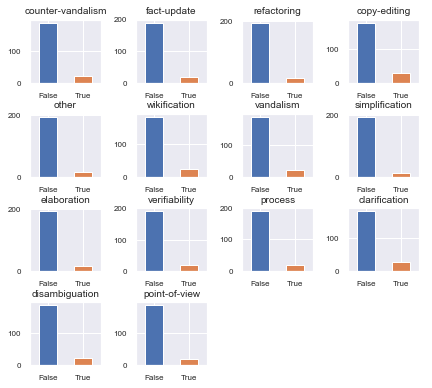

In [218]:
#This approach is called Model-based feature selection. 
#The model judges the importance of each feature and select
#only the most important ones. The thresgold chosen is 0.01 meaning only features whose importance
#is judged as higher than the value will be chosen

#For each possible intention a model is created and evaluated
i = 1
for intention in intentions:    

    #Step to perform feature engineering with the model-based approach
    select = SelectFromModel(
        RandomForestClassifier(random_state = 64),
        threshold=0.01)
    
    select.fit(X_train_[intention], y_train_[intention])
    #Creation of the new train set with the selected attributes
    X_train_l1 = select.transform(X_train_[intention])
    
    #This is to visualize the features chosen
    mask = select.get_support()
    
    df = pandas.DataFrame()
    df['target'] = mask
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8, rotation = 'horizontal')
    plt.yticks(fontsize = 8)
    i += 1
    
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()


In [219]:
scores_all = []
scores_selected = []

fe_rf_precision = []
fe_rf_recall = []
fe_rf_f1 = []
fe_rf_f1_micro = []
fe_rf_f1_macro = []
fe_rf_accuracy = []

for intention in intentions:
    
    #Step to perform feature engineering with the model-based approach
    select = SelectFromModel(
    RandomForestClassifier(random_state = 64),
    threshold=0.01)
    
    select.fit(X_train_[intention], y_train_[intention])
    #Creation of the new train set with the selected attributes
    X_train_l1 = select.transform(X_train_[intention])
    
    #Creation of the model that will fit the data
    lr = RandomForestClassifier(random_state = 64)
    X_test_l1 = select.transform(X_test)
    lr.fit(X_train_l1, y_train_[intention])
    #Calculating the score of the model in the test set with the selected features only
    
    y_pred = lr.predict(X_test_l1)
    fe_rf_precision.append(precision_score(y_test[intention], y_pred))
    fe_rf_recall.append(recall_score(y_test[intention], y_pred))
    fe_rf_f1.append(f1_score(y_test[intention], y_pred))
    fe_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    fe_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    fe_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

fe_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':fe_rf_precision, 'Recall': fe_rf_recall
                                     , 'Accuracy':fe_rf_accuracy, 'F1 Binary':fe_rf_f1, 'F1 micro': fe_rf_f1_micro
                                     , 'F1 macro': fe_rf_f1_macro })
fe_rf_model_data.head(15)


#This is used in the next cell, DataFrame format is given to the scores for easiness in the analysis
#data = pandas.DataFrame({'All features':scores_all,'Selected features':scores_selected})

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.470588,0.500000,0.985062,0.484848,0.985062,0.738635
1,fact-update,0.571429,0.526316,0.942004,0.547945,0.942004,0.758480
2,refactoring,0.392157,0.476190,0.953427,0.430108,0.953427,0.702915
3,copy-editing,0.577670,0.592040,0.851494,0.584767,0.851494,0.747172
4,other,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
5,wikification,0.768868,0.674948,0.775923,0.718853,0.775923,0.766293
6,vandalism,0.459459,0.515152,0.968366,0.485714,0.968366,0.734698
7,simplification,0.522727,0.638889,0.940246,0.575000,0.940246,0.771432
8,elaboration,0.577114,0.670520,0.875220,0.620321,0.875220,0.772831
9,verifiability,0.657143,0.736000,0.928822,0.694340,0.928822,0.827031


In [220]:
averages_rf_fe = []

for column in dummy_model_data_os.iloc[:,1:].columns:

    averages_rf_fe.append(fe_rf_model_data[column].sum()/dummy_model_data_os.shape[0])


base_models_data_comp_fe = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data_comp_fe['Dummy classifier'] = averages_dummy
base_models_data_comp_fe['Random Forest classifier'] = averages_rf
base_models_data_comp_fe['RF classifier after over-sampling'] = averages_rf_os
base_models_data_comp_fe['RF classifier after feature engineering and over-sampling'] = averages_rf_fe
base_models_data_comp_fe.head(15)

,Dummy classifier,Random Forest classifier,RF classifier after over-sampling,RF classifier after feature engineering and over-sampling
Precision,0.088793,0.712241,0.564476,0.490488
Recall,0.075479,0.310874,0.449553,0.486182
Accuracy,0.865993,0.941250,0.936606,0.930580
F1 Binary,0.081318,0.407647,0.494218,0.483384
F1 micro,0.865993,0.941250,0.936606,0.930580
F1 macro,0.498313,0.721357,0.762972,0.755834


[]

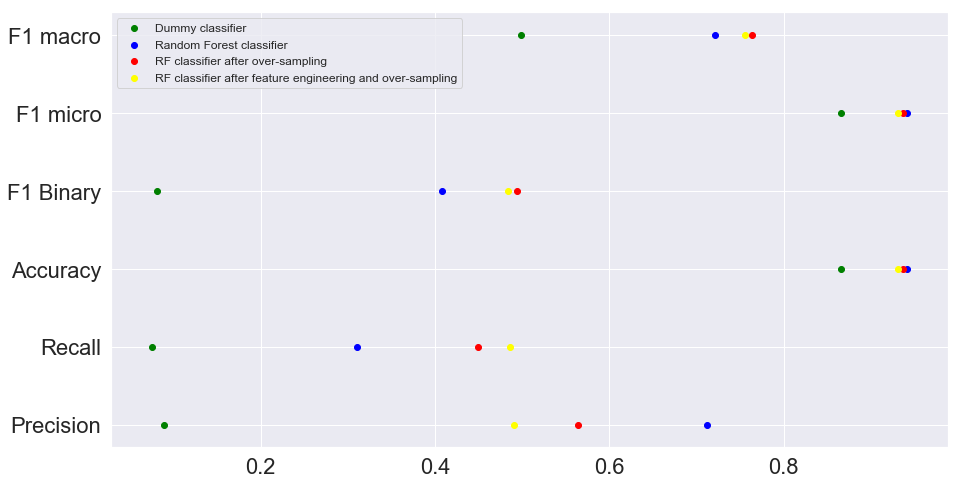

In [221]:
#This visualization shows an scatter plot of the values of the ROC_AUC score for each intention with
#all the attributes and with only the selected attributes in the model-based feature engineering done in the cell above
plt.figure(figsize=(15,8))
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['Dummy classifier'], label = 'Dummy classifier', color= 'green')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['Random Forest classifier'], label =  'Random Forest classifier', color= 'blue')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['RF classifier after over-sampling'], label = 'RF classifier after over-sampling', color = 'red')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['RF classifier after feature engineering and over-sampling'], label = 'RF classifier after feature engineering and over-sampling', color= 'yellow')
plt.legend(loc=2, prop={'size': 12})
plt.plot()


In [237]:
feature_results_comparison = base_rf_model_data_os.merge(fe_rf_model_data, left_on='Intention', right_on='Intention',
                               suffixes=('_os', '_fe'))

feature_results_comparison = feature_results_comparison.drop(axis = 1, labels = ['Accuracy_os','Accuracy_fe', 'F1 micro_os','F1 micro_fe'])
feature_results_comparison.head(15)

,Intention,Precision_os,Recall_os,F1 Binary_os,F1 macro_os,Precision_fe,Recall_fe,F1 Binary_fe,F1 macro_fe
0,counter-vandalism,0.888889,0.500000,0.640000,0.818001,0.470588,0.500000,0.484848,0.738635
1,fact-update,0.551724,0.421053,0.477612,0.722466,0.571429,0.526316,0.547945,0.758480
2,refactoring,0.500000,0.380952,0.432432,0.706679,0.392157,0.476190,0.430108,0.702915
3,copy-editing,0.625000,0.547264,0.583554,0.750440,0.577670,0.592040,0.584767,0.747172
4,other,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
5,wikification,0.761682,0.674948,0.715697,0.762977,0.768868,0.674948,0.718853,0.766293
6,vandalism,0.423077,0.333333,0.372881,0.678096,0.459459,0.515152,0.485714,0.734698
7,simplification,0.582090,0.541667,0.561151,0.766303,0.522727,0.638889,0.575000,0.771432
8,elaboration,0.657609,0.699422,0.677871,0.808972,0.577114,0.670520,0.620321,0.772831
9,verifiability,0.643357,0.736000,0.686567,0.822367,0.657143,0.736000,0.694340,0.827031


Observamos los resultados anteriores y vemos que en algunas categorías los resultados 
se incrementan notablemente, mientras que en otros, al eliminar atributos se genera un perjuicio 
como se puede apreciar en el menor área bajo la curva ROC. 

Es interesante notar la gran diferencia entre determinadas intenciones como por ejemplo refactoring, point of view y disambiguation donde las diferenias en roc_auc score son muy notables con todos los atributos o solo los seleccionados. Sin embargo hay otras intenciones como Wikification o verifiability o clarification donde los resultados siempre son muy similares.

De esto se puede extrar que el dataset tiene una cantidad muy grande de atributos pero que realmente para cada intencion no todos son relevantes. Realizar un estudio de que features concretamente son más decisivas para cada intención es complicado pues el nombre de los features generado es simplemente feature_n, que no arroja mucha información acerca de lo que representa.

Ahora, con esta información vamos a optimizar un modelo utilizando el algoritmo Random Forest. En aquellas intenciones donde la reducción de features es positiva se aplicara el mismo feature engineering de la celda anterior y para cada una de las intenciones los hiperparámetros del modelo serán optimizados. Generando así un random Forest capaz de predecir independientemente cada una de las intenciones. Además, roc_auc scores serán generados para el train set y el test set en función del hiperparámetro a optimizar donde se podrá ver su valor de área bajo la curva y poder optener información acerca de la utilidad del clasificador.

In [254]:
from sklearn.model_selection import GridSearchCV
#Random Forest Optimization
#Parameters to optimize in the random forest, the amount of estimators, which means number of trees in the forest
parameters = {'n_estimators' : [1,2,4,8,16,32,64,128,256,512]}

tuning_rf_precision = []
tuning_rf_recall = []
tuning_rf_f1 = []
tuning_rf_f1_macro = []
tuning_rf_f1_micro = []
tuning_rf_accuracy = []

cv_results_rf_tuning = []

#Loop for each intention
for intention in intentions:
    
    grid_rf = GridSearchCV(RandomForestClassifier(random_state = 64), parameters, cv = 10, scoring = 'f1_macro')
    #fitted on the train set specific for each intention
    grid_rf.fit(X_train_[intention],y_train_[intention])
    df = pandas.DataFrame(grid_rf.cv_results_) 
    cv_results_rf_tuning.append(df)
    #Predictions of the train set (expected to see clear overfitting in the results as im predicting the train set)

    #Now we predict the labels for the new test set and calculate its roc_auc score
    y_pred = grid_rf.predict(X_test)
    tuning_rf_precision.append(precision_score(y_test[intention], y_pred))
    tuning_rf_recall.append(recall_score(y_test[intention], y_pred))
    tuning_rf_f1.append(f1_score(y_test[intention], y_pred))
    tuning_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    tuning_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    tuning_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))

tuning_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':tuning_rf_precision, 'Recall': tuning_rf_recall
                                     , 'Accuracy':tuning_rf_accuracy, 'F1 Binary':tuning_rf_f1, 'F1 micro': tuning_rf_f1_micro
                                     , 'F1 macro': tuning_rf_f1_macro })
tuning_rf_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.700000,0.437500,0.989455,0.538462,0.989455,0.766564
1,fact-update,0.542373,0.421053,0.937610,0.474074,0.937610,0.720456
2,refactoring,0.454545,0.357143,0.960457,0.400000,0.960457,0.689777
3,copy-editing,0.638614,0.641791,0.872583,0.640199,0.872583,0.781391
4,other,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
5,wikification,0.762887,0.766046,0.799649,0.764463,0.799649,0.795075
6,vandalism,0.461538,0.363636,0.969244,0.406780,0.969244,0.695496
7,simplification,0.608696,0.583333,0.949912,0.595745,0.949912,0.784523
8,elaboration,0.654450,0.722543,0.899824,0.686813,0.899824,0.813595
9,verifiability,0.690141,0.784000,0.937610,0.734082,0.937610,0.849371


In [255]:
for dataframe,intention in zip(cv_results_rf_tuning,intentions):
    print(intention + ' Cross Validation results using f1-macro averaged')
    display(dataframe.head(100))

counter-vandalism Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.063949,0.008479,0.001549,0.001695,1,{'n_estimators': 1},0.951894,0.957533,0.965357,0.919415,...,0.994286,0.991554,0.993293,0.991305,0.991803,0.992300,0.994908,0.993542,0.992597,0.001282
1,0.113428,0.029453,0.002691,0.001569,2,{'n_estimators': 2},0.937210,0.955246,0.952983,0.931576,...,0.996398,0.996274,0.995653,0.992547,0.994660,0.995902,0.993914,0.993914,0.994721,0.001217
2,0.228664,0.031949,0.003476,0.001387,4,{'n_estimators': 4},0.956369,0.973172,0.978764,0.940625,...,0.998634,0.999503,0.998758,0.998385,0.998385,0.998758,0.999131,0.998261,0.998795,0.000451
3,0.402860,0.026131,0.005429,0.001652,8,{'n_estimators': 8},0.963092,0.996648,0.984355,0.949610,...,0.999752,0.999627,0.999627,0.999627,0.999379,0.999627,0.999752,0.999503,0.999640,0.000161
4,0.787701,0.033751,0.006760,0.001623,16,{'n_estimators': 16},0.967570,0.998883,0.996648,0.949610,...,0.999752,0.999752,0.999876,0.999876,0.999752,0.999627,0.999752,0.999876,0.999801,0.000099
5,1.546072,0.065658,0.011766,0.000975,32,{'n_estimators': 32},0.972047,0.998883,0.997765,0.927046,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999876,0.999876,0.999975,0.000050
6,2.992675,0.129419,0.021967,0.005611,64,{'n_estimators': 64},0.969807,0.998883,0.997765,0.933855,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,6.118645,0.093915,0.039321,0.001657,128,{'n_estimators': 128},0.974286,0.998883,0.997765,0.938370,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,12.130922,0.157886,0.077919,0.002195,256,{'n_estimators': 256},0.974286,0.998883,0.997765,0.937242,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,23.903061,0.395904,0.150726,0.006838,512,{'n_estimators': 512},0.975405,0.998883,0.997765,0.932725,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


fact-update Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.083114,0.005656,0.001877,0.001890,1,{'n_estimators': 1},0.812824,0.931984,0.933171,0.921454,...,0.974048,0.974961,0.973135,0.972617,0.972097,0.976010,0.972881,0.974576,0.974390,0.002117
1,0.143647,0.009410,0.002526,0.001777,2,{'n_estimators': 2},0.746017,0.940137,0.929481,0.909311,...,0.972599,0.975602,0.973120,0.975475,0.979134,0.976785,0.976001,0.976392,0.976493,0.002865
2,0.262408,0.015459,0.003726,0.001159,4,{'n_estimators': 4},0.809260,0.962484,0.962485,0.955441,...,0.992045,0.990610,0.990479,0.991394,0.991786,0.991916,0.993220,0.992568,0.992241,0.001507
3,0.512765,0.026511,0.004686,0.002058,8,{'n_estimators': 8},0.821169,0.975380,0.981241,0.964829,...,0.996218,0.996348,0.995827,0.997522,0.996219,0.997132,0.997523,0.997262,0.997040,0.000957
4,1.010814,0.054684,0.007700,0.001177,16,{'n_estimators': 16},0.843827,0.975380,0.984758,0.966002,...,0.999348,0.998826,0.998305,0.999218,0.998827,0.999348,0.998957,0.999218,0.999126,0.000421
5,1.919448,0.046331,0.013497,0.002998,32,{'n_estimators': 32},0.858548,0.978898,0.981241,0.968344,...,1.000000,1.000000,0.999739,0.999739,0.999609,0.999609,0.999609,0.999348,0.999739,0.000202
6,3.779601,0.116895,0.024354,0.001543,64,{'n_estimators': 64},0.853454,0.976553,0.982413,0.967174,...,1.000000,0.999870,0.999739,0.999870,0.999870,0.999870,0.999870,0.999870,0.999896,0.000078
7,34.791851,90.897549,0.025263,0.014085,128,{'n_estimators': 128},0.864454,0.974208,0.983586,0.969518,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,6.397732,0.320211,0.039704,0.010395,256,{'n_estimators': 256},0.862076,0.975380,0.983586,0.969517,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,12.388070,0.208532,0.069514,0.000638,512,{'n_estimators': 512},0.865754,0.974208,0.983586,0.965999,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


refactoring Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.038597,0.005065,0.001296,0.000458,1,{'n_estimators': 1},0.903771,0.935981,0.948570,0.971428,...,0.983746,0.983746,0.985524,0.983746,0.984381,0.985524,0.986159,0.984383,0.985130,0.001766
1,0.077590,0.022877,0.000997,0.000002,2,{'n_estimators': 2},0.871780,0.947289,0.957658,0.957671,...,0.986664,0.984122,0.987299,0.985139,0.987299,0.986918,0.985647,0.984252,0.986206,0.001267
2,0.133343,0.023313,0.001596,0.000488,4,{'n_estimators': 4},0.895223,0.959970,0.985142,0.986285,...,0.995301,0.996444,0.997460,0.995936,0.995809,0.994920,0.996698,0.997842,0.996419,0.001003
3,0.262498,0.036443,0.001994,0.000002,8,{'n_estimators': 8},0.906990,0.974850,0.989714,0.979423,...,0.997968,0.998476,0.998476,0.998222,0.997841,0.997968,0.998349,0.998730,0.998425,0.000444
4,0.500661,0.040056,0.002994,0.000010,16,{'n_estimators': 16},0.920874,0.981712,0.985143,0.987428,...,0.999873,0.999746,1.000000,0.999746,0.999619,0.999619,0.999365,0.999492,0.999708,0.000180
5,0.959040,0.033761,0.005085,0.000298,32,{'n_estimators': 32},0.927856,0.977136,0.992000,0.987428,...,1.000000,0.999873,1.000000,0.999873,1.000000,0.999746,0.999873,1.000000,0.999911,0.000099
6,1.945004,0.053066,0.009877,0.001140,64,{'n_estimators': 64},0.934727,0.979424,0.990857,0.983999,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,3.861582,0.075407,0.017555,0.001206,128,{'n_estimators': 128},0.937033,0.980566,0.992000,0.987428,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,7.652036,0.094581,0.032812,0.000830,256,{'n_estimators': 256},0.941627,0.981711,0.993143,0.990857,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,15.838773,0.377091,0.073911,0.012031,512,{'n_estimators': 512},0.938186,0.981711,0.990857,0.986285,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


copy-editing Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.025928,0.002143,0.001293,0.000453,1,{'n_estimators': 1},0.723454,0.717983,0.845113,0.874419,...,0.945188,0.940881,0.944895,0.940153,0.942827,0.944751,0.941485,0.940150,0.944571,0.004473
1,0.044885,0.006816,0.001702,0.000897,2,{'n_estimators': 2},0.667286,0.651064,0.861340,0.870004,...,0.942891,0.940354,0.942297,0.937363,0.942737,0.946024,0.947670,0.945590,0.944755,0.004417
2,0.086663,0.007890,0.002299,0.001003,4,{'n_estimators': 4},0.716725,0.695730,0.895726,0.915887,...,0.982029,0.979504,0.983962,0.980398,0.977724,0.979952,0.980549,0.983667,0.981778,0.002456
3,0.157981,0.011860,0.002393,0.000657,8,{'n_estimators': 8},0.780471,0.741569,0.915873,0.931850,...,0.994207,0.994504,0.994505,0.995545,0.993169,0.994951,0.993615,0.994209,0.994772,0.001066
4,0.304481,0.035210,0.003792,0.001460,16,{'n_estimators': 16},0.814760,0.784019,0.918557,0.945160,...,0.998515,0.998069,0.998515,0.997921,0.998812,0.998069,0.998961,0.998515,0.998530,0.000378
5,0.594112,0.031472,0.005987,0.000638,32,{'n_estimators': 32},0.829581,0.805235,0.922562,0.949179,...,0.999406,0.999703,0.999851,0.999703,0.999703,0.999851,0.999703,0.999703,0.999688,0.000155
6,1.196864,0.049427,0.012670,0.003511,64,{'n_estimators': 64},0.829475,0.827643,0.919882,0.947796,...,1.000000,1.000000,1.000000,0.999851,1.000000,0.999851,0.999852,0.999852,0.999941,0.000073
7,2.365240,0.152723,0.021946,0.006338,128,{'n_estimators': 128},0.833886,0.828947,0.931892,0.953163,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,4.484704,0.084341,0.039793,0.006238,256,{'n_estimators': 256},0.835284,0.841261,0.930553,0.951818,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,9.641114,0.438994,0.080379,0.009275,512,{'n_estimators': 512},0.842079,0.834416,0.930559,0.954518,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


other Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.041527,0.001737,0.002940,0.001265,1,{'n_estimators': 1},0.98791,1.0,1.0,1.0,...,0.999878,0.999878,0.999878,0.999878,1.000000,0.999878,0.999878,0.999633,0.999853,0.000120
1,0.051959,0.002062,0.002402,0.000806,2,{'n_estimators': 2},0.98791,1.0,1.0,1.0,...,0.999878,0.999878,0.999878,0.999878,0.999878,0.999878,0.999878,0.999878,0.999865,0.000037
2,0.081352,0.003771,0.002501,0.000685,4,{'n_estimators': 4},0.98791,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999988,0.000037
3,0.136495,0.007957,0.003587,0.001552,8,{'n_estimators': 8},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.225068,0.016392,0.004214,0.001397,16,{'n_estimators': 16},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.442946,0.032876,0.006784,0.001585,32,{'n_estimators': 32},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.785778,0.076471,0.007943,0.001298,64,{'n_estimators': 64},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,1.338503,0.133304,0.012726,0.001438,128,{'n_estimators': 128},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,3.146601,0.130205,0.027741,0.001421,256,{'n_estimators': 256},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,5.378576,0.560264,0.046954,0.005996,512,{'n_estimators': 512},0.98901,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


wikification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.016605,0.001450,0.001000,0.000017,1,{'n_estimators': 1},0.706390,0.707614,0.713308,0.686129,...,0.890117,0.895605,0.899202,0.892945,0.897177,0.888624,0.896953,0.898461,0.895647,0.004203
1,0.026290,0.000775,0.001193,0.000386,2,{'n_estimators': 2},0.681543,0.709011,0.709243,0.675753,...,0.891119,0.899254,0.905112,0.899341,0.899498,0.894462,0.895364,0.903418,0.898621,0.004078
2,0.055176,0.024108,0.001590,0.000483,4,{'n_estimators': 4},0.760727,0.732639,0.732091,0.751500,...,0.952505,0.953405,0.952536,0.950055,0.951622,0.954953,0.951389,0.955652,0.953475,0.002220
3,0.091776,0.010809,0.002497,0.001495,8,{'n_estimators': 8},0.784542,0.745611,0.779504,0.777256,...,0.982002,0.982680,0.985123,0.982677,0.985122,0.985789,0.982680,0.986459,0.984255,0.001503
4,0.171045,0.013374,0.003089,0.000300,16,{'n_estimators': 16},0.785140,0.785142,0.797511,0.788479,...,0.994008,0.995563,0.996229,0.995563,0.995341,0.997338,0.996007,0.995341,0.995518,0.000982
5,0.338199,0.015728,0.004898,0.000303,32,{'n_estimators': 32},0.798134,0.794956,0.804221,0.795092,...,0.998891,0.998669,0.999335,0.999113,0.998669,0.999556,0.999113,0.998891,0.999024,0.000266
6,0.682524,0.032594,0.009090,0.000838,64,{'n_estimators': 64},0.808653,0.787175,0.824293,0.797454,...,1.000000,1.000000,1.000000,0.999778,1.000000,1.000000,0.999778,1.000000,0.999933,0.000102
7,1.351633,0.048329,0.016507,0.000651,128,{'n_estimators': 128},0.812639,0.803006,0.834548,0.809723,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,2.717931,0.080741,0.040868,0.017481,256,{'n_estimators': 256},0.812737,0.800973,0.836637,0.803533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,5.322835,0.223250,0.067673,0.009038,512,{'n_estimators': 512},0.804769,0.797159,0.828668,0.801465,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


vandalism Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.040288,0.022019,0.001199,0.000399,1,{'n_estimators': 1},0.917802,0.967485,0.978699,0.988788,...,0.992896,0.993270,0.991027,0.991775,0.990654,0.992648,0.991153,0.993396,0.992149,0.001218
1,0.051163,0.003340,0.001098,0.000299,2,{'n_estimators': 2},0.873812,0.968600,0.962971,0.977577,...,0.993021,0.993644,0.993769,0.993395,0.992149,0.992648,0.991402,0.994019,0.993121,0.001125
2,0.093549,0.021814,0.001294,0.000458,4,{'n_estimators': 4},0.910838,0.984305,0.988789,0.989910,...,0.998006,0.997383,0.997258,0.998504,0.998131,0.997882,0.997508,0.998255,0.997881,0.000603
3,0.166457,0.008421,0.002189,0.000393,8,{'n_estimators': 8},0.923420,0.993273,0.997758,0.993273,...,0.999377,0.999377,0.999252,0.999626,0.999502,0.999128,0.999252,0.999502,0.999414,0.000177
4,0.323933,0.021625,0.003091,0.000298,16,{'n_estimators': 16},0.933622,0.992152,0.998879,0.995515,...,0.999751,0.999751,0.999875,0.999875,0.999626,0.999751,0.999751,0.999875,0.999788,0.000080
5,0.661232,0.034442,0.005482,0.002865,32,{'n_estimators': 32},0.942679,0.994394,0.997758,0.996637,...,1.000000,1.000000,1.000000,0.999875,1.000000,1.000000,0.999875,0.999875,0.999963,0.000057
6,1.276583,0.040171,0.009775,0.003762,64,{'n_estimators': 64},0.940403,0.993273,1.000000,0.995515,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,2.537818,0.061600,0.015950,0.000015,128,{'n_estimators': 128},0.940418,0.993273,1.000000,0.994394,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,5.119215,0.103297,0.031013,0.001373,256,{'n_estimators': 256},0.940403,0.993273,1.000000,0.993273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.220168,0.229069,0.060734,0.001296,512,{'n_estimators': 512},0.941535,0.993273,1.000000,0.993273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


simplification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.043684,0.006850,0.001198,0.000399,1,{'n_estimators': 1},0.853715,0.935180,0.924768,0.951389,...,0.974139,0.974912,0.977613,0.976070,0.977356,0.976456,0.977744,0.977234,0.976469,0.001684
1,0.082986,0.022765,0.001698,0.000636,2,{'n_estimators': 2},0.821119,0.933972,0.924672,0.935072,...,0.977868,0.977739,0.980056,0.977225,0.979799,0.979155,0.981603,0.977874,0.979104,0.002285
2,0.130934,0.007828,0.002287,0.001938,4,{'n_estimators': 4},0.852105,0.962963,0.937497,0.964120,...,0.995497,0.995111,0.995497,0.994082,0.995369,0.993439,0.994597,0.993441,0.994623,0.001179
3,0.248736,0.018786,0.002693,0.001413,8,{'n_estimators': 8},0.880108,0.974535,0.965269,0.972215,...,0.997942,0.998199,0.998199,0.998456,0.998199,0.998199,0.998842,0.998071,0.998289,0.000442
4,0.457180,0.023070,0.003489,0.001201,16,{'n_estimators': 16},0.901276,0.978003,0.971044,0.979153,...,0.999228,0.999357,0.999228,0.999743,0.999614,0.999228,0.999743,0.999743,0.999460,0.000243
5,0.891621,0.037030,0.005884,0.002379,32,{'n_estimators': 32},0.909487,0.978003,0.975680,0.977994,...,1.000000,1.000000,1.000000,0.999871,1.000000,0.999743,1.000000,0.999871,0.999923,0.000103
6,1.833394,0.054594,0.010474,0.003853,64,{'n_estimators': 64},0.910698,0.979155,0.975677,0.975680,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,3.643555,0.108566,0.017454,0.000500,128,{'n_estimators': 128},0.910658,0.980316,0.977994,0.976837,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,7.214704,0.117719,0.033810,0.000536,256,{'n_estimators': 256},0.908358,0.977999,0.977994,0.976839,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,15.413180,0.523862,0.078692,0.014471,512,{'n_estimators': 512},0.909547,0.977999,0.976834,0.977996,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


elaboration Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.031616,0.007111,0.001197,0.000399,1,{'n_estimators': 1},0.788912,0.828438,0.911748,0.904175,...,0.958078,0.960071,0.957660,0.960078,0.960504,0.960363,0.959083,0.962924,0.961581,0.003791
1,0.049358,0.002367,0.001302,0.000466,2,{'n_estimators': 2},0.727273,0.790241,0.913103,0.901475,...,0.961900,0.961474,0.964613,0.959627,0.960621,0.963622,0.961342,0.959632,0.962631,0.002586
2,0.098936,0.023051,0.001496,0.000498,4,{'n_estimators': 4},0.768322,0.822794,0.936138,0.950183,...,0.987496,0.987070,0.986930,0.984657,0.984799,0.987926,0.988778,0.987642,0.987356,0.001527
3,0.221502,0.038959,0.003400,0.001791,8,{'n_estimators': 8},0.810752,0.869177,0.947603,0.947570,...,0.995311,0.995595,0.994175,0.995170,0.994743,0.995596,0.995312,0.994460,0.995340,0.000743
4,0.398525,0.038532,0.005292,0.001421,16,{'n_estimators': 16},0.837746,0.882294,0.953968,0.948854,...,0.998721,0.998153,0.999005,0.998437,0.998295,0.998437,0.998295,0.998153,0.998522,0.000325
5,0.824782,0.172177,0.006788,0.001931,32,{'n_estimators': 32},0.850824,0.890015,0.962909,0.952685,...,0.999432,0.999574,1.000000,0.999858,0.999574,0.999716,0.999858,0.999574,0.999702,0.000161
6,1.505707,0.221680,0.010774,0.002433,64,{'n_estimators': 64},0.854831,0.893842,0.961626,0.956533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999986,0.000043
7,2.942391,0.184928,0.021005,0.003152,128,{'n_estimators': 128},0.858818,0.897741,0.961633,0.957808,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,5.741117,0.279706,0.038702,0.005522,256,{'n_estimators': 256},0.866519,0.892611,0.964184,0.956526,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.831558,0.313547,0.071968,0.010270,512,{'n_estimators': 512},0.870392,0.899026,0.962901,0.957808,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


verifiability Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.031016,0.002940,0.001099,0.000300,1,{'n_estimators': 1},0.834356,0.899508,0.949812,0.938399,...,0.973188,0.972075,0.974448,0.974173,0.973056,0.976685,0.975708,0.975429,0.974854,0.001909
1,0.057646,0.009553,0.001397,0.000662,2,{'n_estimators': 2},0.776025,0.877347,0.938464,0.944711,...,0.974854,0.976534,0.977933,0.974163,0.976118,0.977097,0.976538,0.974443,0.976298,0.001348
2,0.104217,0.012532,0.001698,0.000460,4,{'n_estimators': 4},0.821117,0.910668,0.957337,0.963568,...,0.991202,0.990645,0.991483,0.991484,0.990786,0.991344,0.990925,0.993718,0.991734,0.001111
3,0.199570,0.008378,0.002193,0.000598,8,{'n_estimators': 8},0.859450,0.922075,0.964868,0.961052,...,0.996788,0.995532,0.997626,0.996231,0.995253,0.997208,0.996091,0.996649,0.996579,0.000897
4,0.393946,0.022515,0.003391,0.000915,16,{'n_estimators': 16},0.858349,0.932199,0.973651,0.969844,...,0.998604,0.998185,0.999162,0.998604,0.998604,0.999162,0.998325,0.999442,0.998841,0.000410
5,0.783107,0.033593,0.005087,0.000299,32,{'n_estimators': 32},0.873689,0.937229,0.974906,0.968585,...,0.999302,0.999441,0.999441,0.999721,0.999721,0.999581,0.999302,0.999721,0.999539,0.000154
6,1.532202,0.034342,0.008977,0.000002,64,{'n_estimators': 64},0.877600,0.940999,0.969885,0.968587,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999860,1.000000,0.999860,0.999972,0.000056
7,3.111575,0.083338,0.017655,0.002797,128,{'n_estimators': 128},0.880168,0.942263,0.972395,0.968585,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,6.230134,0.068528,0.038698,0.019354,256,{'n_estimators': 256},0.884093,0.944778,0.972395,0.968587,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,12.301900,0.215783,0.064626,0.001466,512,{'n_estimators': 512},0.881493,0.943509,0.974905,0.967329,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


process Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.029621,0.002141,0.000998,3.724217e-07,1,{'n_estimators': 1},0.784909,0.915546,0.887039,0.913095,...,0.968258,0.970246,0.970245,0.966807,0.964427,0.968659,0.969452,0.968794,0.968287,0.001643
1,0.049668,0.001986,0.001297,4.575986e-04,2,{'n_estimators': 2},0.748707,0.914163,0.900929,0.893102,...,0.972995,0.972468,0.972864,0.970877,0.973527,0.971672,0.972866,0.969950,0.972466,0.001585
2,0.090059,0.001266,0.001496,4.984379e-04,4,{'n_estimators': 4},0.788097,0.948856,0.938130,0.948730,...,0.991799,0.993519,0.991535,0.992461,0.992726,0.992593,0.992329,0.990875,0.992077,0.000898
3,0.170748,0.007139,0.001997,3.284989e-06,8,{'n_estimators': 8},0.817780,0.971462,0.963137,0.970223,...,0.998413,0.997355,0.997355,0.997223,0.997487,0.997620,0.997223,0.998413,0.997791,0.000549
4,0.326141,0.011768,0.003088,2.996080e-04,16,{'n_estimators': 16},0.833236,0.980975,0.970273,0.982141,...,0.998942,0.999736,0.999471,0.998942,0.999339,0.999207,0.999074,0.999339,0.999312,0.000270
5,0.640589,0.012910,0.005385,6.614249e-04,32,{'n_estimators': 32},0.851105,0.984542,0.979786,0.985713,...,0.999735,0.999736,1.000000,0.999868,0.999868,0.999603,0.999603,0.999603,0.999775,0.000133
6,1.270905,0.019817,0.009970,1.029861e-05,64,{'n_estimators': 64},0.851105,0.982164,0.982164,0.986903,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999987,0.000040
7,2.561257,0.051896,0.018848,5.389754e-04,128,{'n_estimators': 128},0.857382,0.984542,0.979786,0.984522,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,5.155115,0.081549,0.036502,4.893906e-04,256,{'n_estimators': 256},0.856218,0.988109,0.979786,0.986903,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.151448,0.114538,0.071508,7.797482e-04,512,{'n_estimators': 512},0.858634,0.986920,0.978597,0.985713,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


clarification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.037498,0.005190,0.001292,0.000452,1,{'n_estimators': 1},0.818003,0.932625,0.937280,0.900105,...,0.976224,0.969763,0.973256,0.974806,0.970417,0.973776,0.971709,0.972355,0.973876,0.003225
1,0.063135,0.004728,0.001193,0.000400,2,{'n_estimators': 2},0.790920,0.934812,0.931296,0.907563,...,0.978153,0.976082,0.977377,0.977765,0.973758,0.973886,0.974275,0.976087,0.976524,0.002784
2,0.117295,0.005406,0.001215,0.000390,4,{'n_estimators': 4},0.810827,0.962823,0.972119,0.960488,...,0.992893,0.993926,0.992247,0.993669,0.992636,0.992636,0.992378,0.993153,0.993217,0.001473
3,0.240261,0.032681,0.002297,0.000637,8,{'n_estimators': 8},0.826882,0.983740,0.976767,0.979093,...,0.996899,0.997286,0.997287,0.997804,0.997545,0.997675,0.997416,0.998191,0.997623,0.000652
4,0.441618,0.009871,0.003198,0.000404,16,{'n_estimators': 16},0.833424,0.982578,0.980253,0.984901,...,0.998966,0.999095,0.999483,0.999096,0.999612,0.999483,0.999354,0.999483,0.999315,0.000283
5,0.883645,0.036647,0.005584,0.000489,32,{'n_estimators': 32},0.840793,0.988385,0.987224,0.989547,...,0.999612,1.000000,0.999742,0.999612,0.999871,1.000000,1.000000,1.000000,0.999871,0.000153
6,1.727481,0.024024,0.010076,0.000298,64,{'n_estimators': 64},0.843280,0.988385,0.986063,0.988386,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,3.478001,0.059078,0.018946,0.000439,128,{'n_estimators': 128},0.843169,0.990708,0.986063,0.990708,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,7.124362,0.219757,0.038297,0.001196,256,{'n_estimators': 256},0.846895,0.991870,0.989547,0.990708,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,13.932749,0.247918,0.074799,0.003595,512,{'n_estimators': 512},0.846895,0.990708,0.989547,0.990708,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


disambiguation Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.032912,0.005221,0.000997,4.271620e-07,1,{'n_estimators': 1},0.874408,0.920128,0.982019,0.964044,...,0.989263,0.989139,0.989388,0.989139,0.991011,0.988889,0.990637,0.989889,0.989813,0.000902
1,0.050165,0.005277,0.001196,3.990906e-04,2,{'n_estimators': 2},0.842682,0.911782,0.968512,0.967394,...,0.991011,0.992634,0.993133,0.991635,0.993258,0.992134,0.991385,0.991636,0.991997,0.000838
2,0.096236,0.005856,0.001598,4.852251e-04,4,{'n_estimators': 4},0.887528,0.948230,0.984268,0.986516,...,0.997628,0.998127,0.997753,0.997378,0.998002,0.998127,0.997628,0.998502,0.997990,0.000423
3,0.184009,0.010190,0.001996,1.005948e-05,8,{'n_estimators': 8},0.916386,0.944815,0.995506,0.991011,...,0.999126,0.999376,0.999001,0.999501,0.999001,0.999251,0.999001,0.999501,0.999276,0.000222
4,0.360040,0.016598,0.003593,6.678411e-04,16,{'n_estimators': 16},0.927810,0.939149,0.998876,0.994382,...,0.999251,0.999376,0.999251,0.999625,0.999625,0.999625,0.999501,0.999626,0.999526,0.000166
5,0.677491,0.037393,0.005083,2.910939e-04,32,{'n_estimators': 32},0.924389,0.941430,0.997753,0.992134,...,0.999625,0.999750,0.999625,0.999750,0.999875,0.999875,0.999750,0.999750,0.999725,0.000109
6,1.353487,0.022299,0.009371,4.849653e-04,64,{'n_estimators': 64},0.931226,0.953869,0.997753,0.992134,...,0.999750,0.999875,0.999750,0.999750,0.999875,0.999875,0.999750,0.999750,0.999788,0.000057
7,2.704368,0.072117,0.017956,4.469822e-04,128,{'n_estimators': 128},0.930088,0.953869,0.997753,0.992134,...,0.999750,0.999875,0.999750,0.999750,0.999875,0.999875,0.999750,0.999750,0.999788,0.000057
8,5.326845,0.093450,0.034610,4.592261e-04,256,{'n_estimators': 256},0.928949,0.945958,0.997753,0.994382,...,0.999750,0.999875,0.999750,0.999750,0.999875,0.999875,0.999750,0.999750,0.999788,0.000057
9,10.645141,0.151679,0.068413,2.562249e-03,512,{'n_estimators': 512},0.933500,0.953869,1.000000,0.994382,...,0.999750,0.999875,0.999750,0.999750,0.999875,0.999875,0.999750,0.999750,0.999788,0.000057


point-of-view Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.046876,0.024860,0.000996,0.000003,1,{'n_estimators': 1},0.870993,0.926799,0.940303,0.943691,...,0.977846,0.983979,0.982227,0.977845,0.983729,0.977720,0.984356,0.981854,0.981839,0.002833
1,0.068121,0.012125,0.001294,0.000456,2,{'n_estimators': 2},0.860627,0.911883,0.919666,0.918547,...,0.983728,0.987358,0.984103,0.984479,0.987358,0.984478,0.985482,0.985983,0.985831,0.001827
2,0.122775,0.014993,0.001698,0.000459,4,{'n_estimators': 4},0.893188,0.949290,0.968456,0.954936,...,0.995870,0.996370,0.996370,0.995995,0.996120,0.996996,0.996621,0.996371,0.996483,0.000720
3,0.223106,0.009748,0.002194,0.000400,8,{'n_estimators': 8},0.908230,0.968468,0.979729,0.990991,...,0.999499,0.999249,0.998748,0.999249,0.998623,0.999374,0.999499,0.999374,0.999136,0.000417
4,0.445509,0.018393,0.003292,0.000638,16,{'n_estimators': 16},0.920856,0.990990,0.987612,0.993243,...,1.000000,0.999875,0.999625,0.999625,0.999625,0.999875,0.999875,0.999875,0.999812,0.000140
5,0.883041,0.021397,0.005983,0.001407,32,{'n_estimators': 32},0.931079,0.992116,0.988739,0.995495,...,1.000000,0.999875,0.999750,0.999875,0.999875,0.999875,0.999750,0.999875,0.999875,0.000079
6,1.772667,0.049922,0.009670,0.000456,64,{'n_estimators': 64},0.932182,0.996622,0.987612,0.996622,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,3.519883,0.094799,0.018052,0.000300,128,{'n_estimators': 128},0.929901,0.995495,0.988739,0.996622,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,7.027704,0.152676,0.035406,0.000505,256,{'n_estimators': 256},0.935598,0.993243,0.988739,0.997748,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,14.037071,0.240908,0.069413,0.000798,512,{'n_estimators': 512},0.941284,0.994369,0.988739,0.997748,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [256]:
averages_rf_tuned = []

for column in dummy_model_data_os.iloc[:,1:].columns:

    averages_rf_tuned.append(tuning_rf_model_data[column].sum()/dummy_model_data_os.shape[0])


base_models_data_comp_fe['Tuned RF with OS'] = averages_rf_tuned


base_models_data_comp_fe.head(15)

,Dummy classifier,Random Forest classifier,RF classifier after over-sampling,RF classifier after feature engineering and over-sampling,Tuned RF with OS
Precision,0.088793,0.712241,0.564476,0.490488,0.552381
Recall,0.075479,0.310874,0.449553,0.486182,0.467761
Accuracy,0.865993,0.941250,0.936606,0.930580,0.939744
F1 Binary,0.081318,0.407647,0.494218,0.483384,0.500538
F1 micro,0.865993,0.941250,0.936606,0.930580,0.939744
F1 macro,0.498313,0.721357,0.762972,0.755834,0.766998


In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


#List to store all the pipelines to export 
models = []

class_weight = dict({1:2, 0:300})

# Fit model
i = 0
for intention in intentions:
    #Creation of a pipeline to automatize the process of the feature engineering where it is used
    pipeline = Pipeline([
                ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64),
                    threshold=0.01)),
                ('classifier', RandomForestClassifier(class_weight = class_weight, random_state = 64, n_estimators = best_hyperparameters[i]))])
    #If no feature engineering is good to go for this specific intention as the positive_intention matrix identifies then none is done.
    if positive_intention[intention] == False:
        pipeline = RandomForestClassifier(class_weight = class_weight, random_state = 64, n_estimators = best_hyperparameters[i])
    
    pipeline.fit(X_train_[intention],y_train_[intention])
    roc_auc= calculate_roc(pipeline, X_test, y_test[intention])
    models.append(pipeline)
    #Just to ensure that the results are the same as the selected model of above
    print('Intention: ' + intention + ' AUC_ROC score with best hyperparameter: ' + str(roc_auc) + '-' + str(best_hyperparameters[i]))
    i += 1

    
print('Models succesfully saved')

Intention: counter-vandalism AUC_ROC score with best hyperparameter: 0.8397393048128342-512
Intention: fact-update AUC_ROC score with best hyperparameter: 0.771582912082466-128
Intention: refactoring AUC_ROC score with best hyperparameter: 0.7729840111226973-256
Intention: copy-editing AUC_ROC score with best hyperparameter: 0.7820980476486299-256
Intention: other AUC_ROC score with best hyperparameter: nan-1
Intention: wikification AUC_ROC score with best hyperparameter: 0.7880312297504465-512
Intention: vandalism AUC_ROC score with best hyperparameter: 0.8211161387631974-64
Intention: simplification AUC_ROC score with best hyperparameter: 0.8296852199291224-64
Intention: elaboration AUC_ROC score with best hyperparameter: 0.8202012638893049-16
Intention: verifiability AUC_ROC score with best hyperparameter: 0.8953721618953602-64
Intention: process AUC_ROC score with best hyperparameter: 0.7645816391072559-16
Intention: clarification AUC_ROC score with best hyperparameter: 0.704526136

Llegados a este punto ya tenemos guardados y entrenados los mejores modelos en una lista. En este caso los modelos seleccionados son los del random forest creados mediante el valor de n_estimators que genera un mayor valor de área bajo la curva ROC. Además, todos los random forest de este notebook tienen random_state = 64 por motivos de reproducibilidad. Así se observa que los mejores valores obtenidos durante el tuning, son los mismos que los valores arrojados por la creación del modelo final.

En la celda siguiente, se exportarán los modelos a una carpeta llamada trained_models donde cada uno llevará el nombre de la intención que predice.

In [260]:
from sklearn.externals import joblib
import os
import shutil
#Remove the already existing trained model (if existing) and create a new folder for the new models
#This way we also guarantee that there wont be redundant models. 
#If you want to keep older models, change them to another folder.
shutil.rmtree('trained_models', ignore_errors=True)
os.mkdir('trained_models')
#Then we just assign the name of the intention and export with joblib extension.
model_index = 0
for intention in intentions:
    joblib.dump(models[model_index], 'trained_models/'+intention+'_classificator.joblib')

print("Models exported succesfully")

Models exported succesfully


Como se puede ver en las anteriores gráficas tanto como del modelo con SVM como con Random Forest el overfitting es muy alto. 


En el caso del random forest los resultos del test set son aceptables: los resultados obtenidos en el test set de área bajo la curva ROC son aceptables en la mayoría de los casos. Llegando a valores de casi 0,9 en algunos casos. La facilidad con la que el modelo clasifica las intenciones varía mucho de unas a otras, en ese sentido es muy poco uniforme. Así, Point of view no llega ni a 0,7 en el mejor de los casos. No obstante ya es una mejoría frente a los modelos existentes.

En el caso de las SVM diferentes kernels han sido probados, así como también se probó realizar feature engineering para ese clasificador con otro SVM, sin embargo en ninguno de los casos probados los resultados arrojados han sido positivos. Entiendo que probablemente hay algún error mío ahí y algún tipo de preprocesamiento es necesario primero para poder generar una SVM con utilidad. El overfitting es muy alto y los resultados en general pobres el valor más común es 0.5 de área bajo la curva ROC que implica que el clasificador básicamente toma decisiones aleatorias.

Por lo tanto el modelo escogido es aquel generado por el Random Forest, el valor para el hiperparámetro "n_estimators" varía para cada intención. El mejor modelo para cada intención (aquel con mayor valor de área bajo la curva) se introduce en un pipeline que generara feature engineering automáticamente antes de predecir en las intenciones en las cuales genera un impacto positivo. Así, las pipelines entrenadas son exportadas para poder ser ejecutadas desde una consola de comandos como parte del workflow del proceso de descargar un dump de una wiki y tener el dataset listo para la minería de procesos.

# Clasificación multi-label

En esta sección del notebook se realiza la clasificación multilabel. La clasificación multilabel es básicamente aquella donde cada data point puede tener una o más labels, sin ser estas excluyentes entre sí como en la clasificacion multiclass.

Antes de nada se debe realizar un poco de preprocesamiento del dataset, para ello se ha creado una función (se encuentra al inicio del dataset donde he definido todas las funciones de las que hago uso) llamada creatingMultilabel que básicamente junta las 14 columbas de intencion en una dandole el formato adecuado. Después se aplica MultiLabelBinarizer para darle forma de sparse matrix (matriz donde la mayoría de valores son 0) adecuada para los algoritmos de scikit-learn.

Se comenzará analizando el dataset, viendo la proporción de cada intención y aquellas revisiones en las cuales haya más de una intención. En esteo caso se ven revisiones que se podrían considerar outliers como es el caso de aquellas en las que hay hasta 5 intenciones diferentes al mismo tiempo por su escasez en el dataset. Sin embargo no se realizará ninguna técnica para eliminar este tipo de revisiones del dataset.

Se creará una pipeline donde probar diferentes modelos y se generará una gráfica viendo la evolución de la métrica f1 con averaging 'sample' útil para medir la eficiencia de un predictor multilabel.

Una vez hecho esto comienza la selección del algoritmo clasificador. En este caso diferentes algoritmos han sido testeados mediante diferentes técnicas. RandomForest y KNN. El motivo por el cual he decidido usar estos clasificadores es básicamente el tipo de datos utilizados. Se trata de una tarea de clasificación multilabel con un dataset de tamaño reducido pero con un número alto de atributos. Los atributos, además, son de tipo FLOAT. Dado que es no es texto Naive Bayes no nos es útil. Debido a que el target es multilabel los algoritmos de regresión no son adecuados. Además por cantidad de datos una red neuronal probablemente tenga problemas de precisión al ser un dataset de solo 5500 muetras.

In [64]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from skmultilearn.adapt import MLkNN
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
y = creating_multilabel(y)
y = MultiLabelBinarizer().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
#Figures size
plt.rcParams['savefig.dpi'] = 100




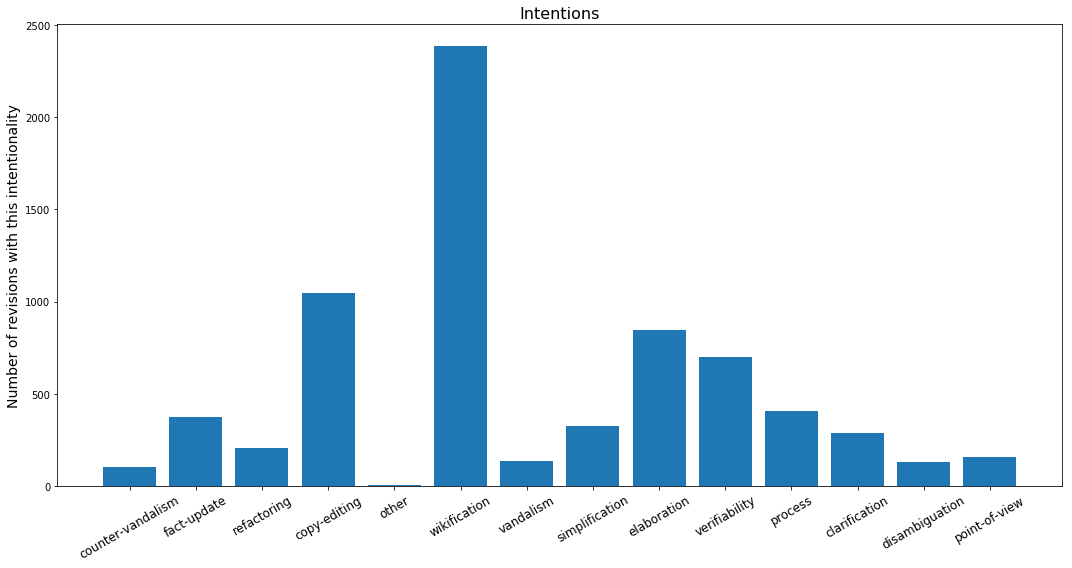

In [65]:
plt.figure(figsize=(15,8))
ax= plt.bar(intentions, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions", fontsize = 16)
plt.ylabel('Number of revisions with this intentionality', fontsize = 14)
plt.xticks(intentions,rotation = 30, fontsize = 12)
plt.tight_layout()
plt.show()


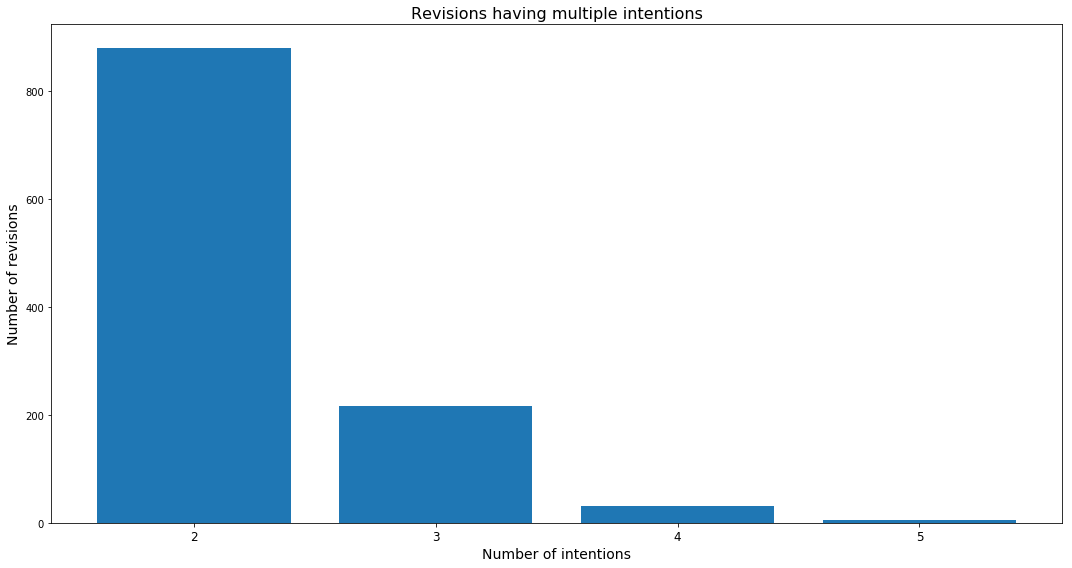

In [66]:
rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
plt.figure(figsize=(15,8))
ax = plt.bar(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Revisions having multiple intentions", fontsize = 16)
plt.ylabel('Number of revisions', fontsize = 14)
plt.xlabel('Number of intentions', fontsize = 14)
plt.xticks(multiLabel_counts.index, fontsize = 12)
plt.tight_layout()
plt.show()

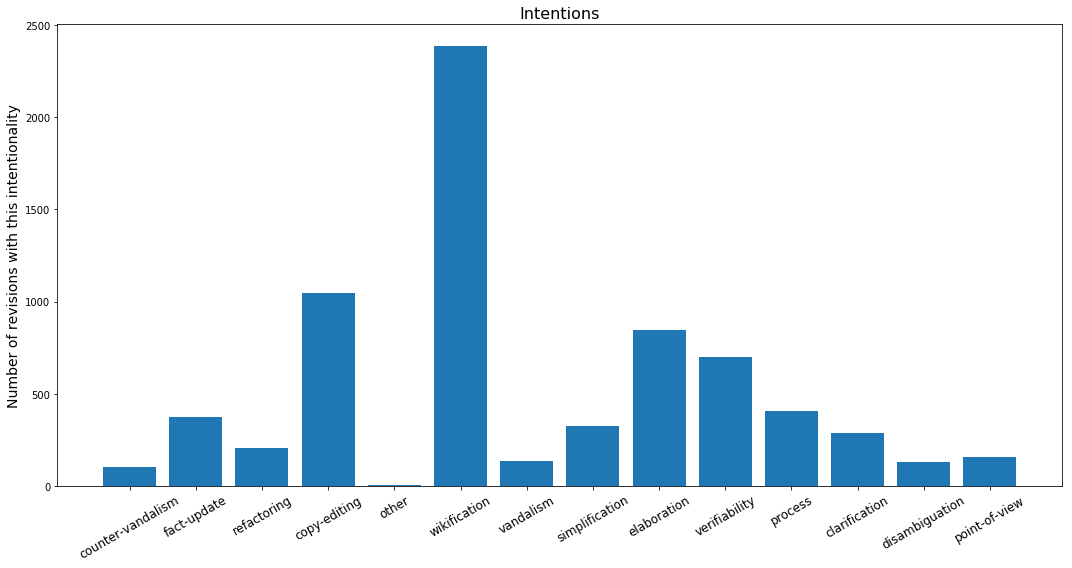

In [67]:
plt.figure(figsize=(15,8))
ax= plt.bar(intentions, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions", fontsize = 16)
plt.ylabel('Number of revisions with this intentionality', fontsize = 14)
plt.xticks(intentions,rotation = 30, fontsize = 12)
plt.tight_layout()
plt.show()

In [68]:
dummy_ML_data = pandas.DataFrame()


    
baseline_model = DummyClassifier(random_state = 64)
baseline_model.fit(X_train, y_train)
    
y_pred = baseline_model.predict(X_test)
dummy_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
dummy_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
dummy_ML_data.head(15)



,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.084136,0.083625,0.083367,0.207635,0.083367,0.067663


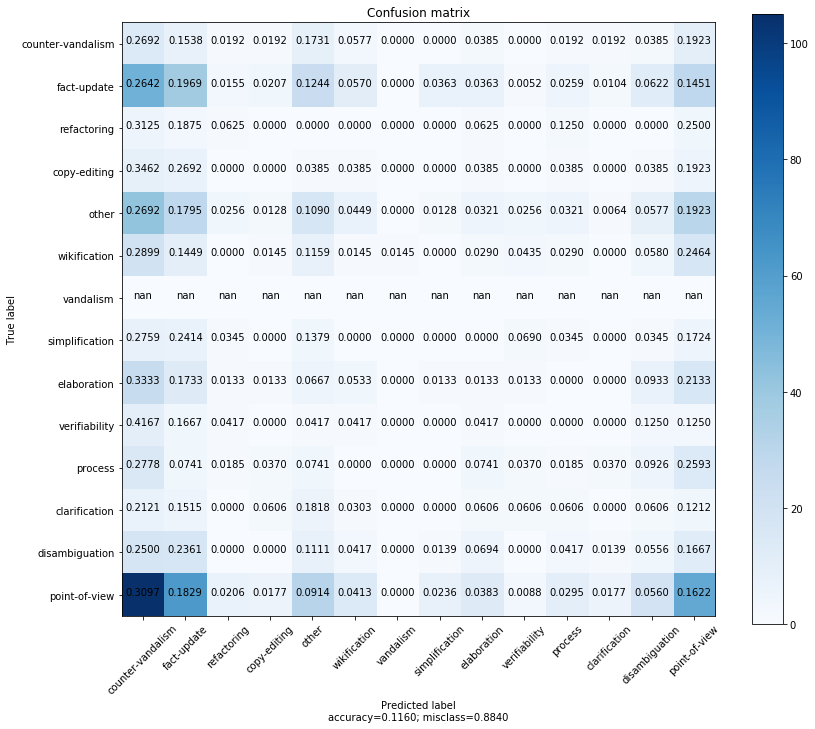

In [69]:
cm_ML_dummy = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_dummy, intentions)


In [70]:
base_rf_ML_data = pandas.DataFrame()


    
base_rf_ML_model = RandomForestClassifier(random_state = 64)
base_rf_ML_model.fit(X_train, y_train)
    
y_pred = base_rf_ML_model.predict(X_test)
base_rf_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_rf_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_rf_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.613507,0.266754,0.34891,0.565102,0.34891,0.403339


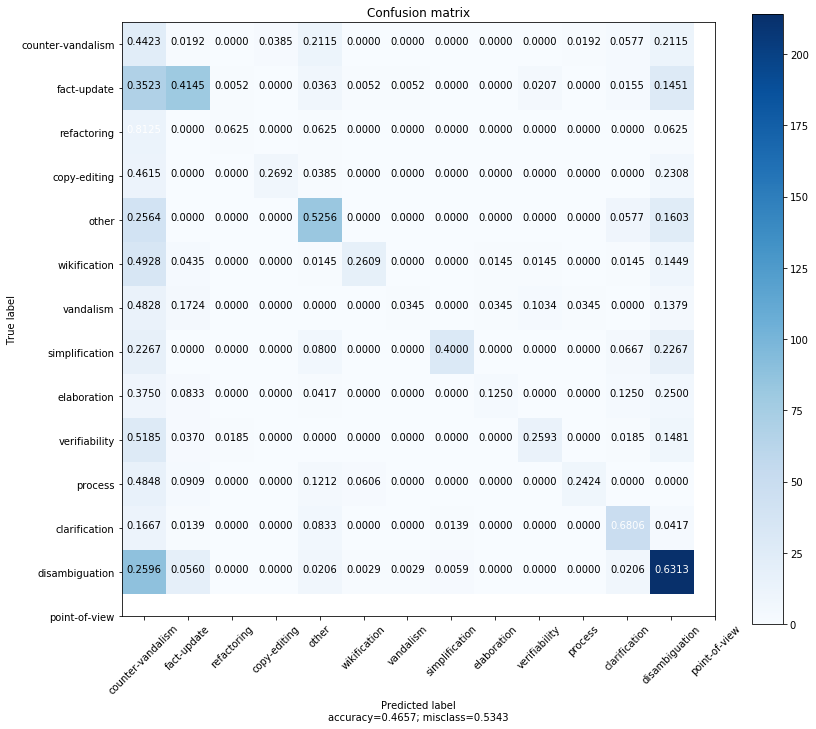

In [71]:
cm_ML_rf = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf, intentions)

In [107]:
base_KNN_ML_data = pandas.DataFrame()


    
base_KNN_ML_model = MLkNN()
base_KNN_ML_model.fit(X_train, y_train)
    
y_pred = base_KNN_ML_model.predict(X_test)
base_KNN_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_KNN_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_KNN_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.395635,0.100178,0.145273,0.263557,0.145273,0.167838


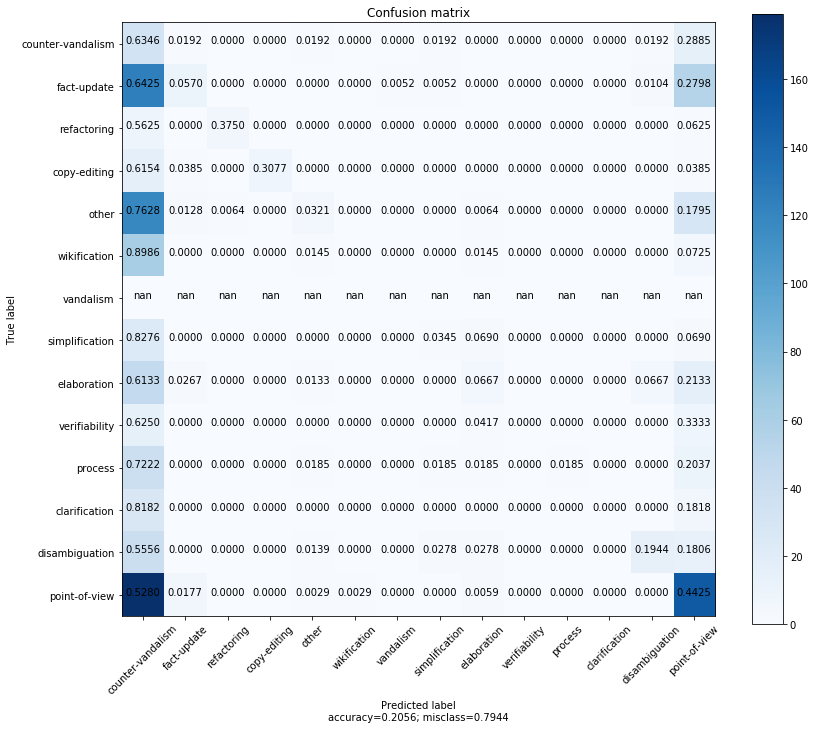

In [108]:
cm_ML_KNN = confusion_matrix(y_test.argmax(axis=1), y_pred.toarray().argmax(axis=1))

plot_confusion_matrix(cm_ML_KNN, intentions)

In [105]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)

base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN
Precision,0.084136,0.613507,0.395635
Recall,0.083625,0.266754,0.100178
F1 Score,0.083367,0.348910,0.145273
F1 micro,0.207635,0.565102,0.263557
F1 macro,0.083367,0.348910,0.145273
Accuracy,0.067663,0.403339,0.167838


Se puede observar que el dataset no está particularmente balanceado sin embargo al ser 14 intenciones diferentes no se aplicará ninguna estrategia para balancear. Es llamativo no obstante el caso de la intención "other". Tanto en la primera sección del notebook como esta, se observa que en sí es un outlier y realmente no sé hasta que punto merece la pena si quiera mantenerlo en el dataset. Es una intención cuya utilidad es determinadar aquellas revisiones donde lo realizado no encaje en ninguna de las otras intenciones, sin embargo los casos son tan poco frecuentes que de aproximadamente 5500 muestras, solo 2 pertenecían a other y al ser un dataset creado a mano realmente no tenemos garantía de que efectivamente esas revisiones catalogadas como other realmente pertenezcan a other.

En cuanto a la cantidad de revisiones con más de 1 intencionalidad los resultados son más bajos de lo esperado. Con esto se puede ver que una un alto porcentaje de las revisión son para realizar cambios específicos que probablemente vaya muy unido al hecho de los roles existentes entre los editores de las wikis, donde aquellos usuarios "todo-terrenos" son escasos.

In [122]:
parameters_ML_KNN = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,15,20,25,30]}
parameters_ML_RF = {'n_estimators' : [1,2,4,8,16,32,64,128,256,512]}

base_rf_ML_fe_data = pandas.DataFrame()

#Step to perform feature engineering with the model-based approach
select = SelectFromModel(
RandomForestClassifier(random_state = 64),
threshold=0.01)
    
select.fit(X_train, y_train)
#Creation of the new train set with the selected attributes
X_train_l1 = select.transform(X_train)
    
#Creation of the model that will fit the data
base_rf_ML_fe_model = RandomForestClassifier(random_state = 64)
X_test_l1 = select.transform(X_test)
base_rf_ML_fe_model.fit(X_train_l1, y_train)
#Calculating the score of the model in the test set with the selected features only
    
y_pred = base_rf_ML_fe_model.predict(X_test_l1)
base_rf_ML_fe_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_rf_ML_fe_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_rf_ML_fe_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.754929,0.288348,0.383403,0.57004,0.383403,0.40246


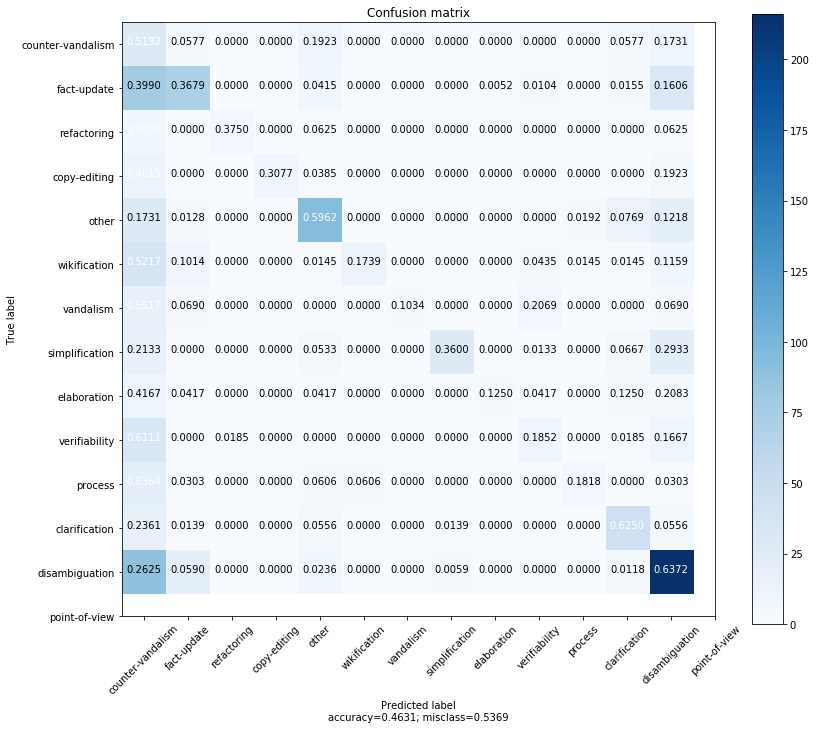

In [124]:
cm_ML_rf_fe = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf_fe, intentions)

He ido haciendo un modelo "encima" del otro en lugar de conservar cada modelo probado dentro de esta sección del notebook debido a los peores resultados en general en comparación con la clasificación realizada en el apartado previo. (Al ser facilmente reproducibles no tendría problema para recrearlos si fuera necesario.

Como se puede ver en la gráfica de KNN el overfitting es bastante pequeño según aumenta el número de vecinos, sin embargo los resultados son muy pobres por lo que es un modelo dificilmente útil.

# Dummie para probar predictores

Esta zona del notebook es dummie, esta parte será transladada a un script aparte que importe los modelos anteriormente exportadp. El motivo de que esté aún aquí es por facilidad a la hora de probarlo frente a un archivo de .py común.

In [ ]:
#Dummie to test the predictions of the article leche
#Tried to merge the dataframes of each intention into a complete one but
#was unable to do it, had to usea cheap version with a dictionary

leche = pandas.read_csv('revision_ids_leche_featured.csv', sep=',')
X_leche, y_leche = leche.iloc[:, :-14], dataset.iloc[:, -14:]

intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

#results = pandas.DataFrame(columns = intentions)
results = {'revision_id':[],'counter-vandalism':[],'fact-update':[],'refactoring':[],'copy-editing':[],'other':[],'wikification':[],
            'vandalism':[],'simplification':[],'elaboration':[],'verifiability':[],'process':[],'clarification':[],'disambiguation':[],
            'point-of-view':[]}

results['revision_id'] = leche.iloc[:,0]

for intention in intentions:
    
    #results_intention = pandas.Series([], name = intention)
    #results_intention = pandas.DataFrame( columns = [intention])
    
    print("Predicting labels for " + intention)
    
    lr.fit(X_train, y_train[intention])
    predictions_leche = lr.predict(X_leche)
    
    for line in predictions_leche:
        #results_intention = results_intention.append({intention:line}, ignore_index = True)
        #results_intention.add(line)
        #results.loc[results.index[counter], intention] = line
        results[intention].append(line)
        
print("Labels predicted")
        
results_dataframe = pandas.DataFrame.from_dict(results)
    #results = pandas.concat([results,results_intention], axis = 1, sort = False)
    #results = results.merge(results_intention, how = 'outer')
      

results_dataframe.to_csv(path_or_buf = 'leche_labels.csv', index = False)




In [107]:
#Now the idea is to add the created labels to the initial parsed dump

output = pandas.read_csv('leche.csv', sep=',')

attributes = {'page_id':[], 'page_title':[], 'page_ns':[], 'revision_id':[],'intentionality':[],'timestamp':[],
       'contributor_id':[], 'contributor_name':[], 'bytes':[]}

#values = {'counter-vandalism':'0','fact-update':'1','refactoring':'2','copy-editing':'3','other':'4','wikification':'5',
#            'vandalism':'6','simplification':'7','elaboration':'8','verifiability':'9','process':'10','clarification':'11',
#          'disambiguation':'12','point-of-view':'13'}

labels = [None] * len(results_dataframe.index)



#output = pandas.DataFrame.to_dict(output)

for intention in intentions:
    
    offset = 0
    
    for line in results[intention]:
        
        if labels[offset] == None:
            labels[offset] = str(results['revision_id'][offset]) + ':'
        if line == 1:
            labels[offset] = labels[offset] + intention + ','
        
        offset += 1

        
labels_dataframe = pandas.DataFrame(columns=['revision_id', 'intentionality'])
for line in labels:
   
    data = line.split(':')
    data_id = data[0]
    data_intention = data[1]
    
    data = pandas.DataFrame({'revision_id':[data_id],'intentionality':[data_intention]})
    labels_dataframe = labels_dataframe.append(data)


labels_dataframe['revision_id']=labels_dataframe['revision_id'].astype(int)
output = output.merge(labels_dataframe, on = 'revision_id', how = 'inner')


output.to_csv(path_or_buf = 'leche_dataset_process_mining.csv', index = False)
